# `CLOUD.jl` - 2D linear advection

In [91]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_dgmulti_2D_skew_p4M4_linear_test/"
results_path = "../results/advection_dgmulti_2D_skew_p4M4_test/";

Define the physical problem

In [92]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a collapsed-edge scheme of degree `p` with `M` intervals in each direction

Set plotting and post-processing options

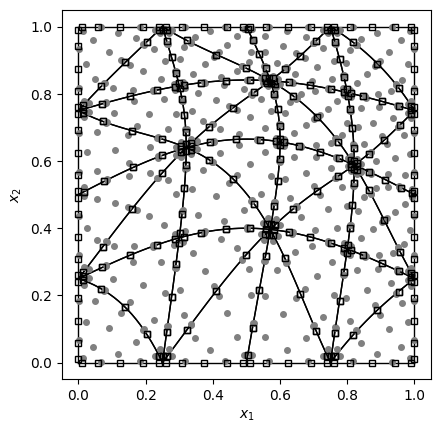

In [93]:
M = 4
p = 4
p_map = p
form = SplitConservationForm()
mesh_strategy = ZigZag()
strategy=Lazy()

reference_approximation =ReferenceApproximation(
    DGMulti(p), Tri(), mapping_degree=p_map,
    N_plot=ceil(Int,50/M));
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), strategy=mesh_strategy), 
    reference_approximation.reference_element, 0.1)
spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation);
solver = Solver(conservation_law, spatial_discretization, form, strategy)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    grid_lines=false, plot_volume_nodes=true, geometry_resolution=20)

In [94]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

tol = 1.0e-12
n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s-2
linear_analysis = LinearAnalysis(results_path, conservation_law, spatial_discretization,
    LinearResidual(solver), r=r, tol=tol)
plotter = Plotter(spatial_discretization, plots_path);

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [95]:
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
reset_timer!()
sol = solve(ode_problem, Tsit5(), adaptive=false,
    dt=dt, save_everystep=false, 
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
print_timer()
save_solution(last(sol.u), last(sol.t), results_path, "final")

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            44.6s /  98.8%           30.0GiB /  99.9%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 rhs!                   31.0k    44.0s  100.0%  1.42ms   29.9GiB  100.0%  0.99MiB
   eval residual         992k    17.7s   40.2%  17.8μs   14.7GiB   49.1%  15.5KiB
     volume terms        992k    9.62s   21.8%  9.69μs   11.9GiB   39.7%  12.5KiB
     mass matrix solve   992k    2.45s    5.6%  2.47μs   2.26GiB    7.6%  2.39KiB
     facet terms         992k    319ms    0.7%   322ns    197MiB    0.6%     208B
   eval flux diff        992k    9.71s   22.1%  9.79μs   7.11GiB   23.8%  7.52KiB
   eval flux   

Visualize the solution

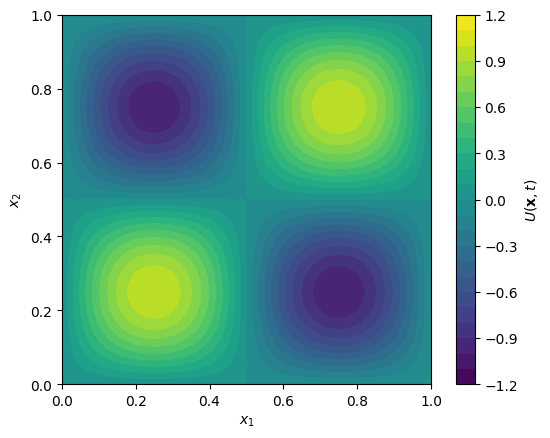

In [96]:
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

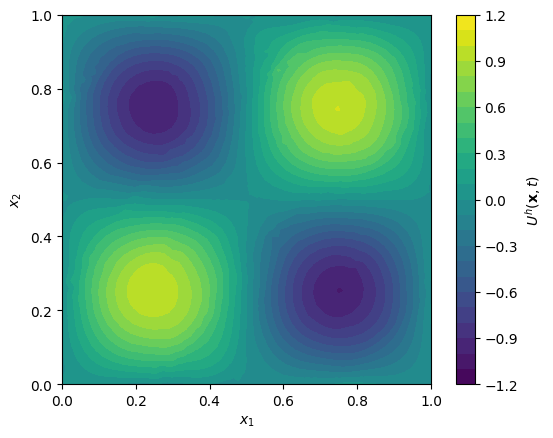

In [97]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [98]:
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.009802557622223703]
Conservation (initial/final/diff):
[-1.4530229013823975e-7][-1.4530229082692497e-7][-6.886852199627924e-16]
Energy (initial/final/diff):
[0.24998950035810052][0.24998950035810075][2.220446049250313e-16]


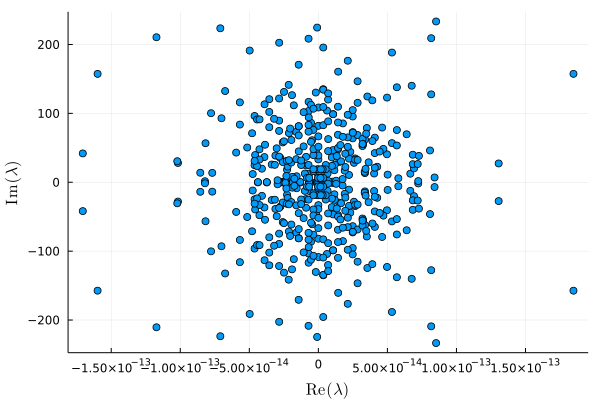

In [99]:
linear_results = analyze(linear_analysis)
plot_spectrum(linear_analysis, linear_results.λ, unit_circle=false, label="\\lambda", numbering=false)